In [109]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [8]:
from math import log10, ceil, sqrt
import numpy as np
import scipy.linalg as la
import scipy.sparse as sps
import matplotlib.pyplot as plt
%matplotlib inline
# try to load a local style sheet for matplotlib
# see http://matplotlib.org/users/style_sheets.html
try:
    plt.style.use('presentation')
except:
    pass # do nothing if it cannot be found

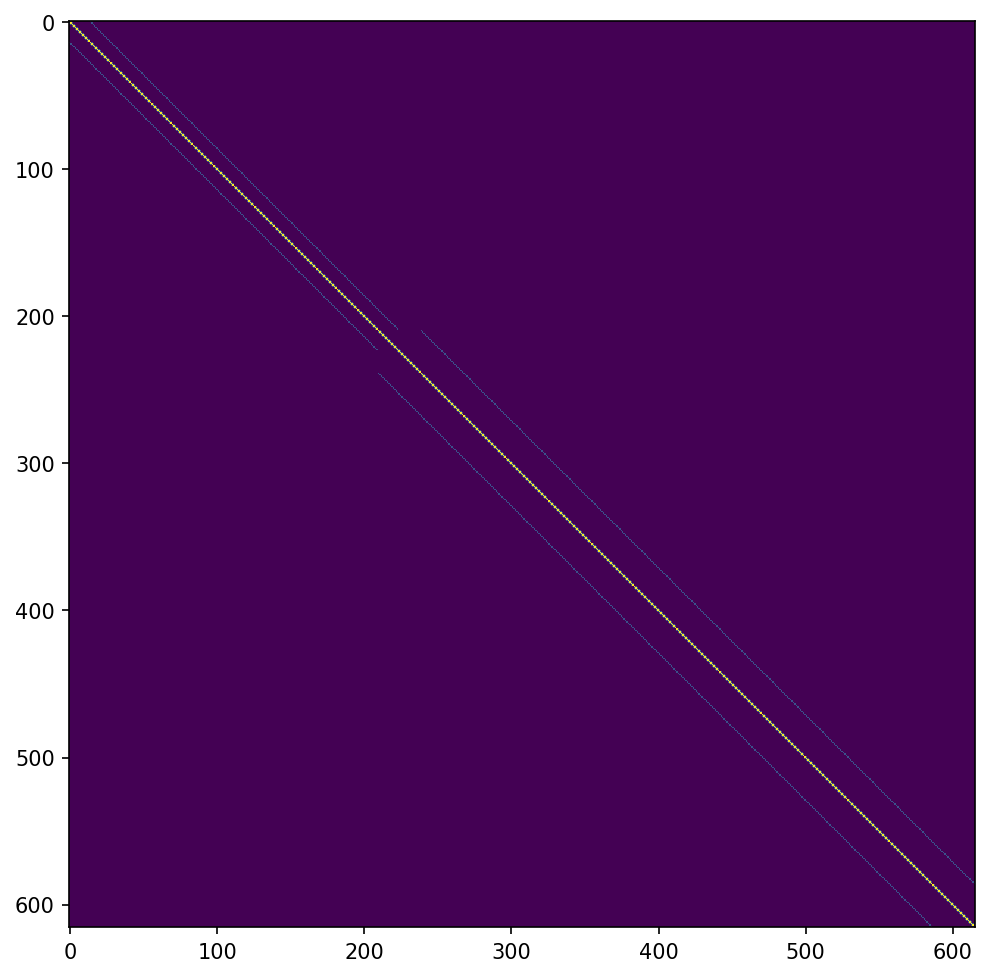

In [9]:
def numgrid(n, verbose=False):
    x = np.ones((n,1))*np.linspace(-1,1,n)
    y = np.flipud(x.T)
    G = (x > -1) & (x < 1) & (y > -1) & (y < 1) & ((x < 0) | (y < 0))
    if verbose:
        print('\nBoundary values (0) and degrees of freedom (.) on domain:')
        print(np.where(G, '.', '0'))
    G = np.where(G,1,0) # boolean to integer
    k = np.where(G)
    G[k] = np.arange(1, len(k[0])+1)
    if verbose:
        print('\nDegree of freedom numbering:')
        print(G)
    return G

def delsq(G, verbose=False):
    [m,n] = G.shape
    # Indices of interior points
    G1 = G.flatten()
    p = np.where(G1)[0]
    if verbose:
        print('\nIndices of degrees of freedom on square grid:')
        print(p)
    N = len(p)
    # Connect interior points to themselves with 4's.
    i = G1[p]-1
    j = G1[p]-1
    s = 4*np.ones(p.shape)

    if verbose:
        print('\nConnected degrees of freedom:')
    # for k = north, east, south, west
    for k in [-1, m, 1, -m]:
        # Possible neighbors in k-th direction
        Q = G1[p+k]
        # Index of points with interior neighbors
        q = np.where(Q)[0]
        if verbose:
            print(np.vstack((Q[q], G1[p[q]])))
        # Connect interior points to neighbors with -1's.
        i = np.concatenate([i, G1[p[q]]-1])
        j = np.concatenate([j,Q[q]-1])
        s = np.concatenate([s,-np.ones(q.shape)])
    # sparse matrix with 5 diagonals
    return sps.csc_matrix((s, (i,j)),(N,N))

G = numgrid(31)
A = delsq(G)
plt.figure(figsize=(8,8), dpi=150)
plt.imshow(abs(A.todense()))
plt.show()

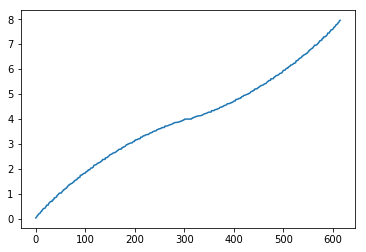

In [24]:
w, v = la.eig(A.todense())
w = w[w.real == w].real
plt.plot(sorted(w))

In [75]:
print("cond2(A) = %f" % (max(w) / min(w)))

cond2(A) = 185.036298


In [42]:
def split_DLR(A):
    D = np.diag(np.diag(A))
    L = sps.tril(A, k=-1, format='csc')
    R = sps.triu(A, k=1, format='csc')
    return((D, L, R))

In [28]:
def jacobi(A):
    D, L, R = split_DLR(A)
    J = -la.inv(D) * (L + R)
    return J

In [32]:
def SOR(A, ω):
    D, L, R = split_DLR(A)
    Hω = la.inv(D + ω * L) * ((1 - ω) * D - ω * R)
    return(Hω)

In [33]:
def gauß_seidel(A):
    return(SOR(A, 1))

In [49]:
J = jacobi(A.todense())
H1 = gauß_seidel(A.todense())
ω = 2 / (1 + sqrt(1 - 0.990553216332 * 0.990553216332))
Hω = SOR(A.todense(), ω)

In [114]:
def plt_eig(A, s, l):
    w, v = la.eig(A)
    plt.figure(figsize=(8,8), dpi=250)
    plt.plot(w.real, w.imag, s, label=l, markersize=1)
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.legend()
    plt.show()

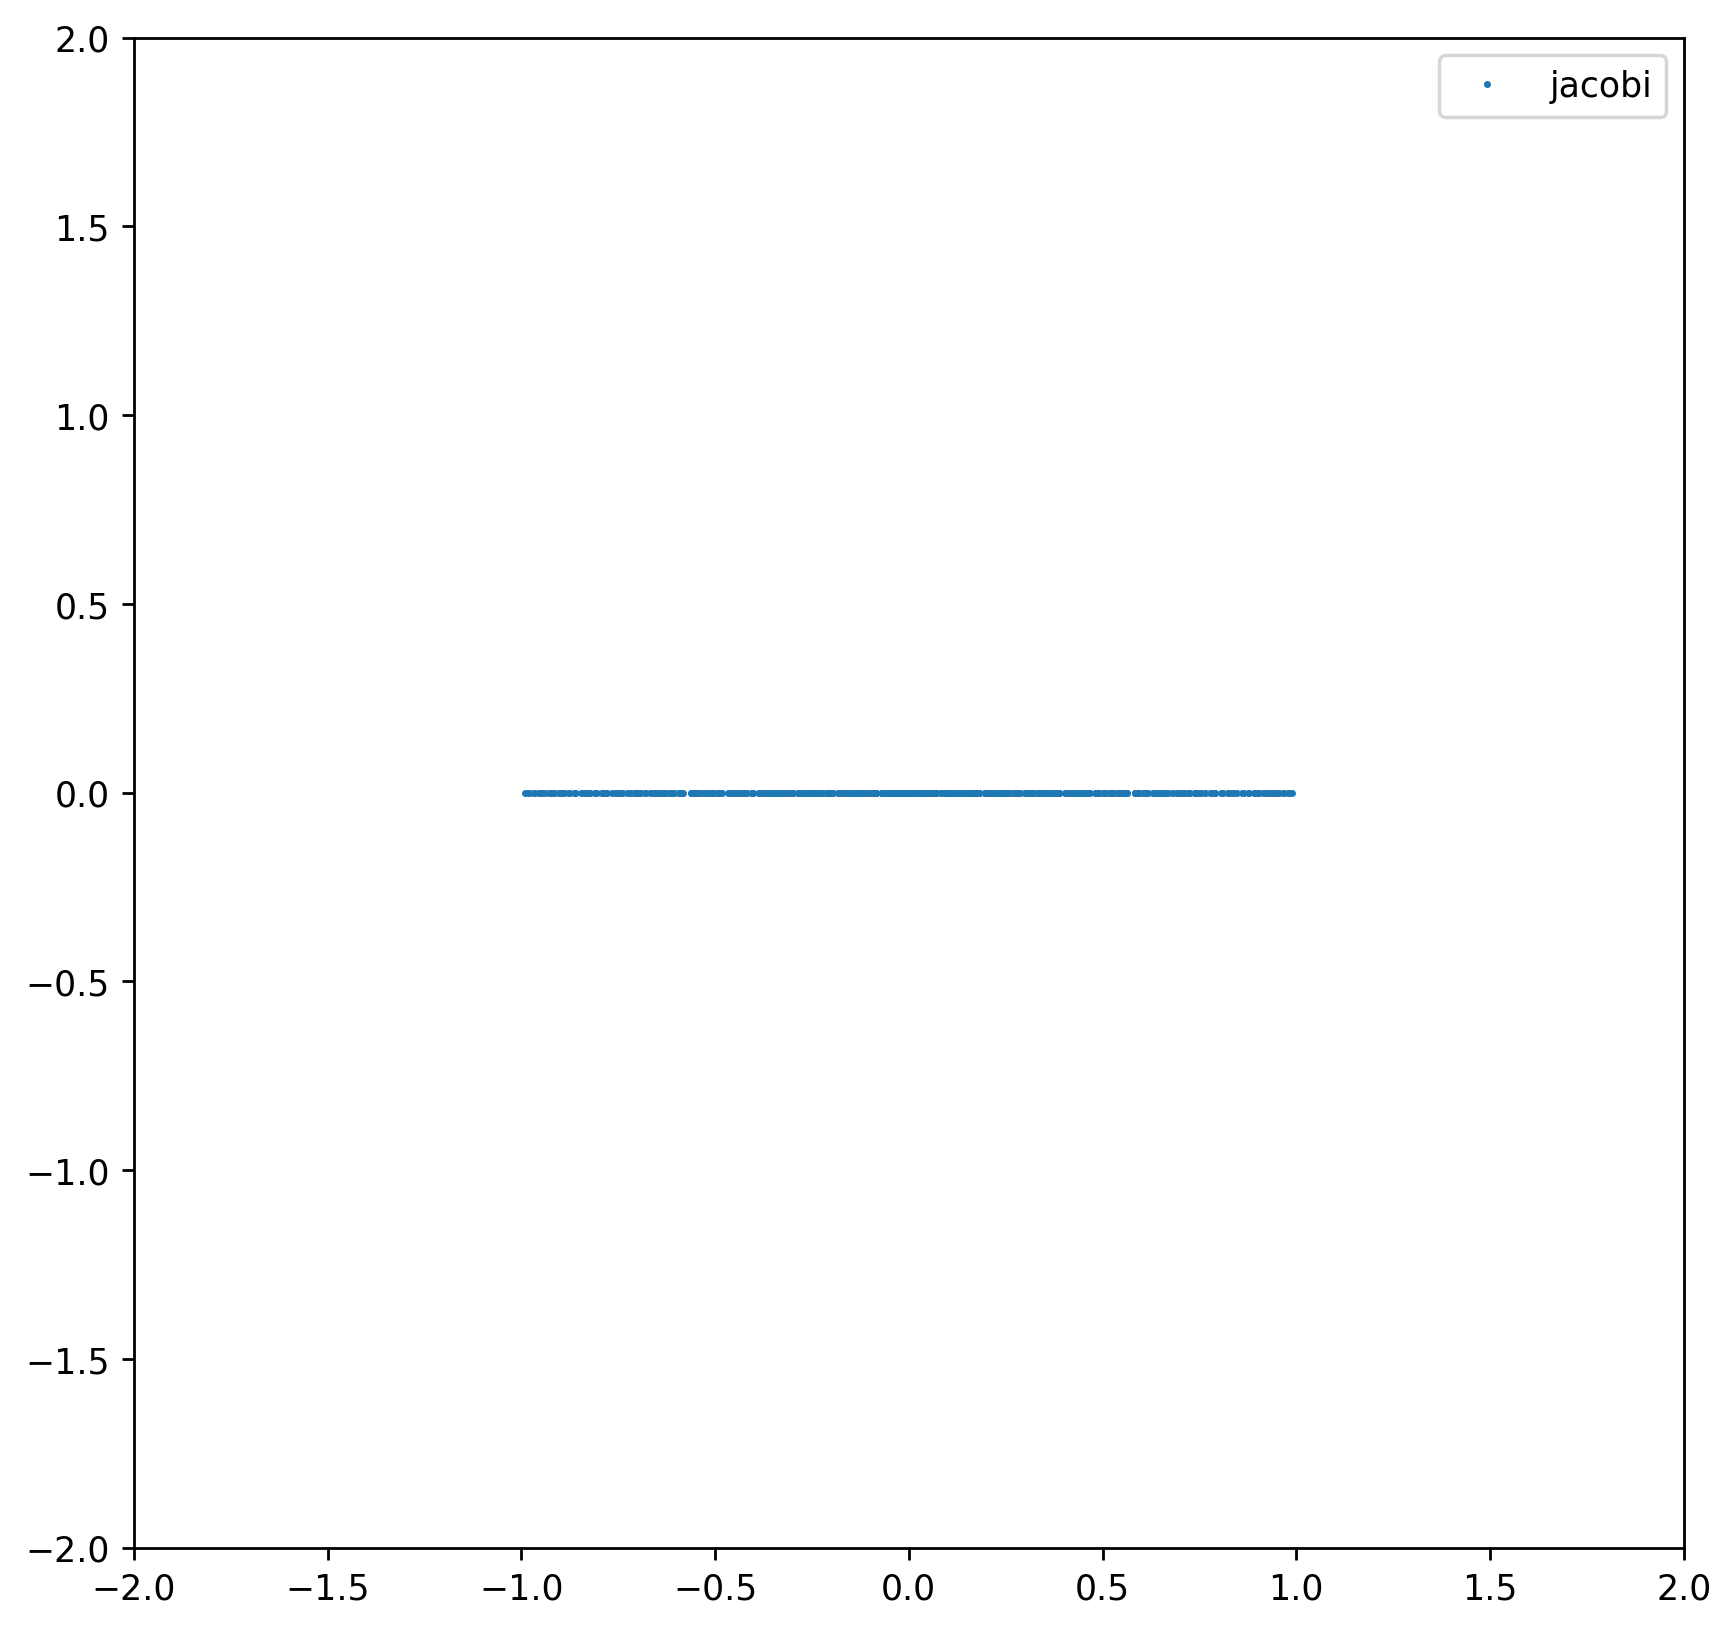

In [115]:
plt_eig(J, 'o', 'jacobi')

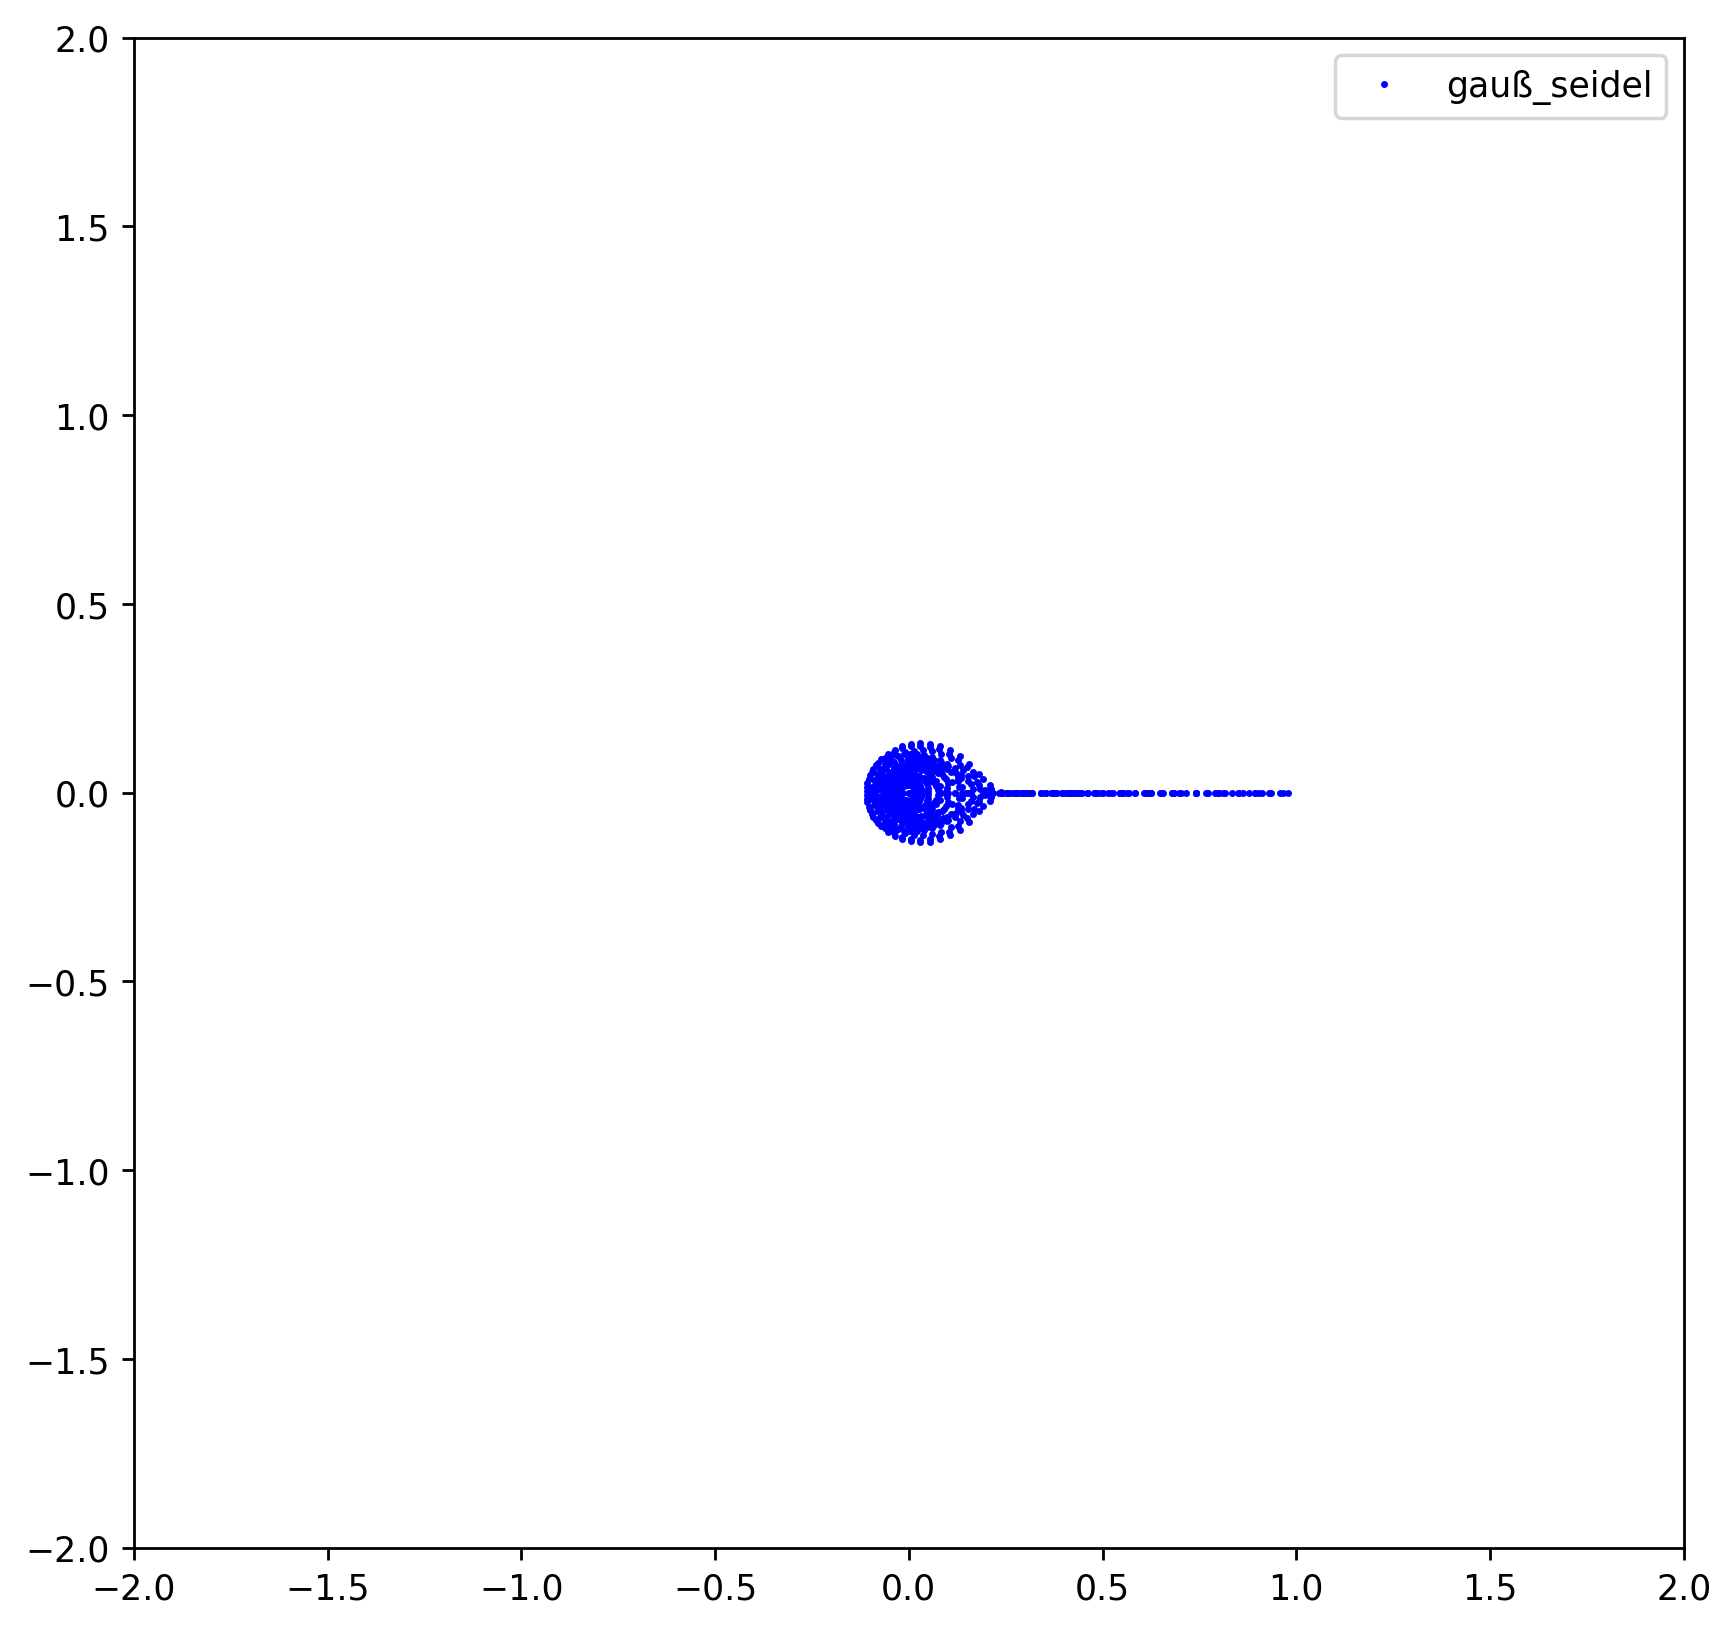

In [116]:
plt_eig(H1, 'bo', 'gauß_seidel')

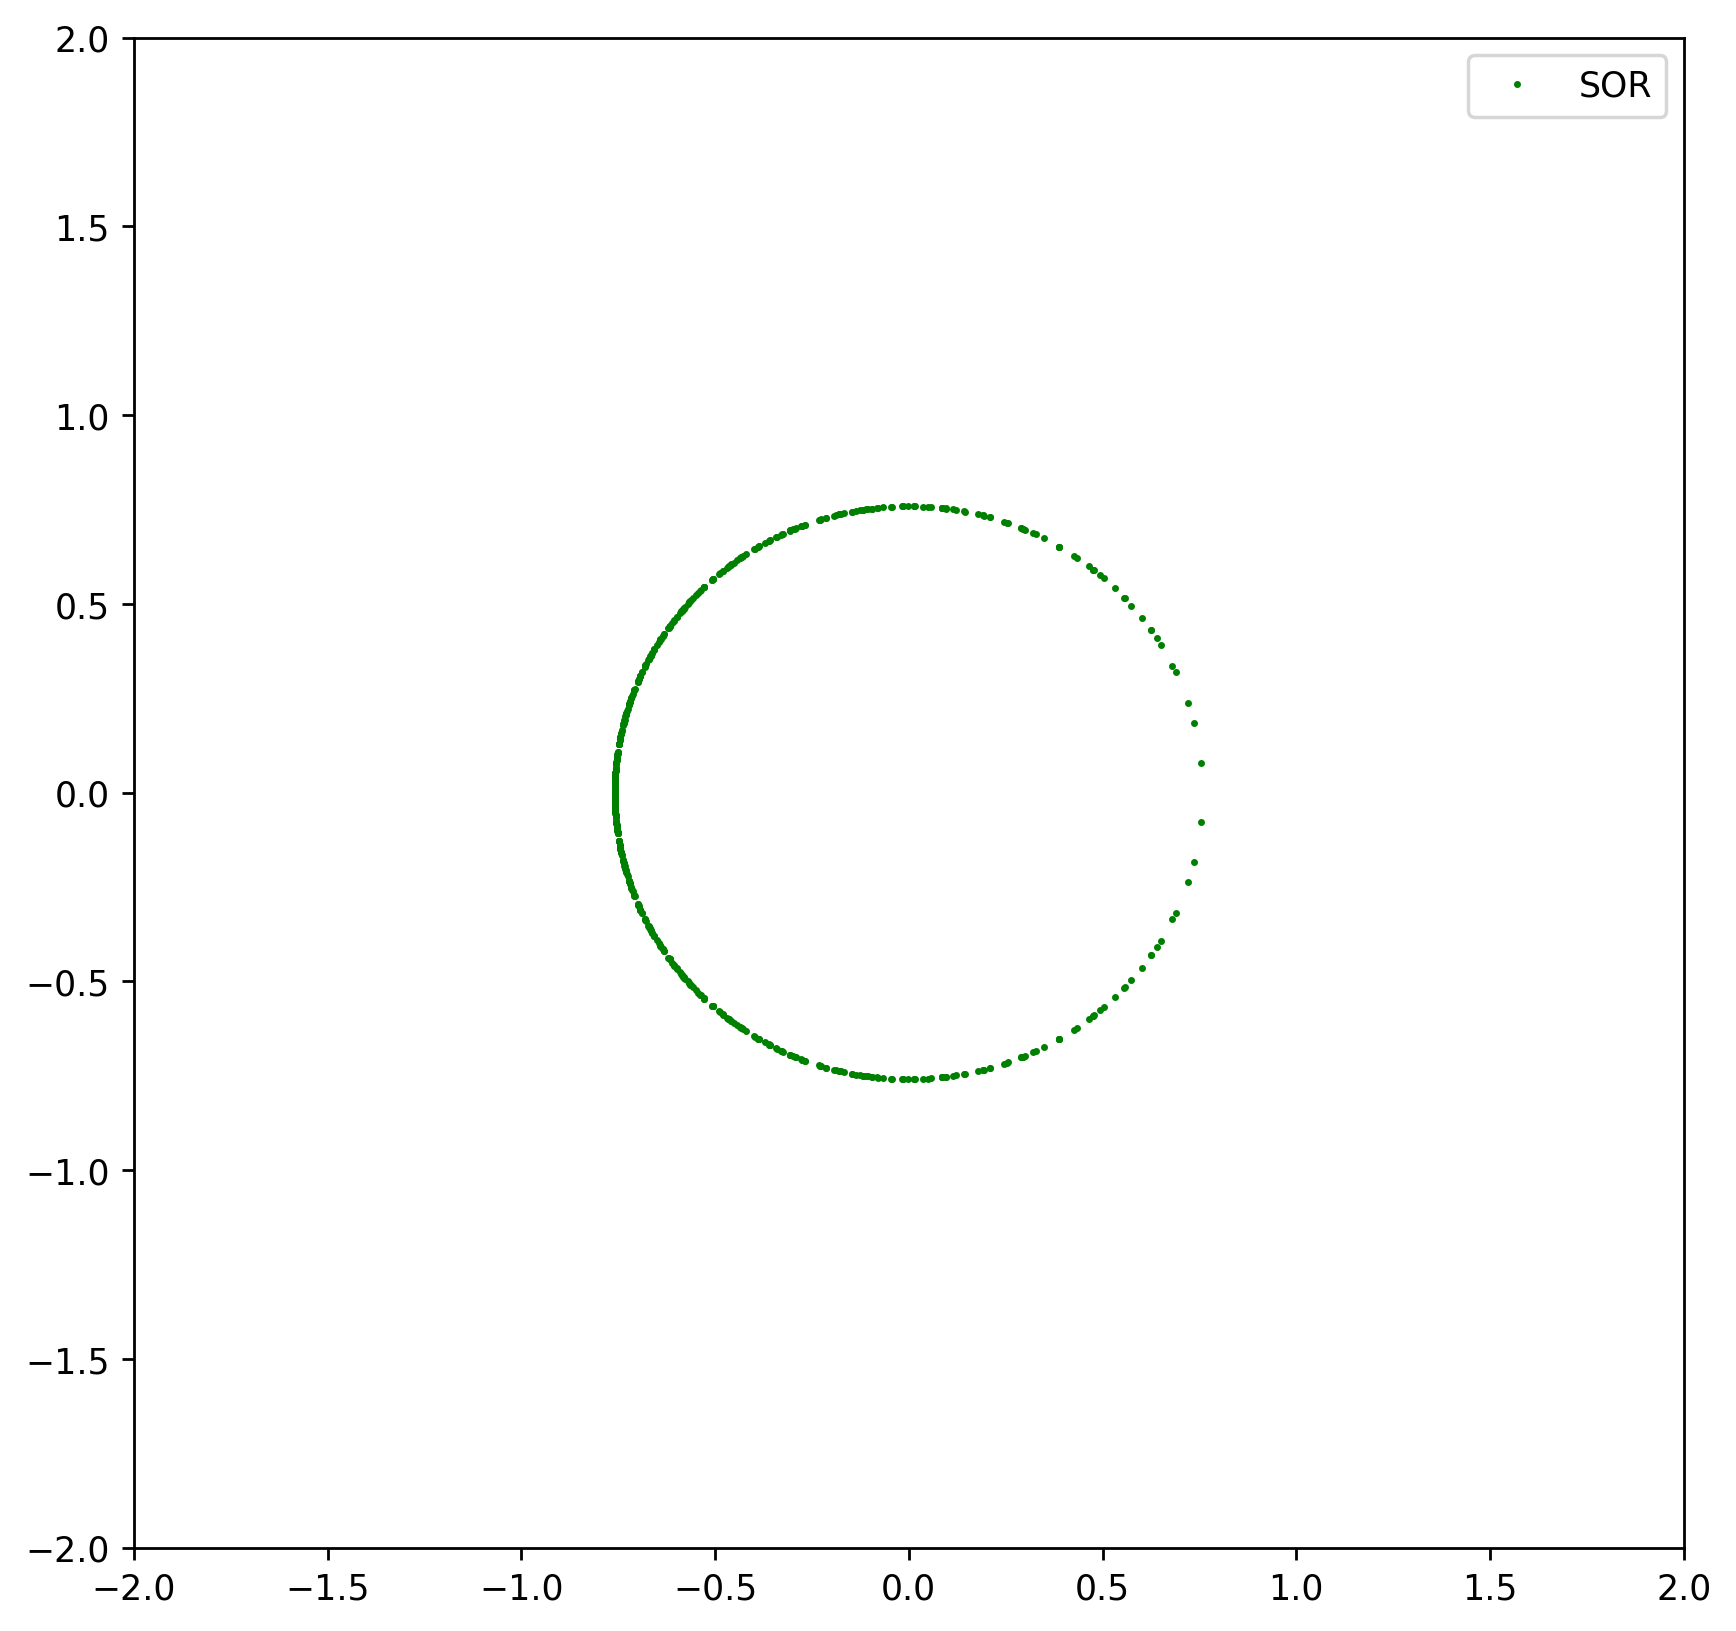

In [117]:
plt_eig(Hω, 'go', 'SOR')

In [118]:
from matplotlib import animation
from IPython.display import HTML

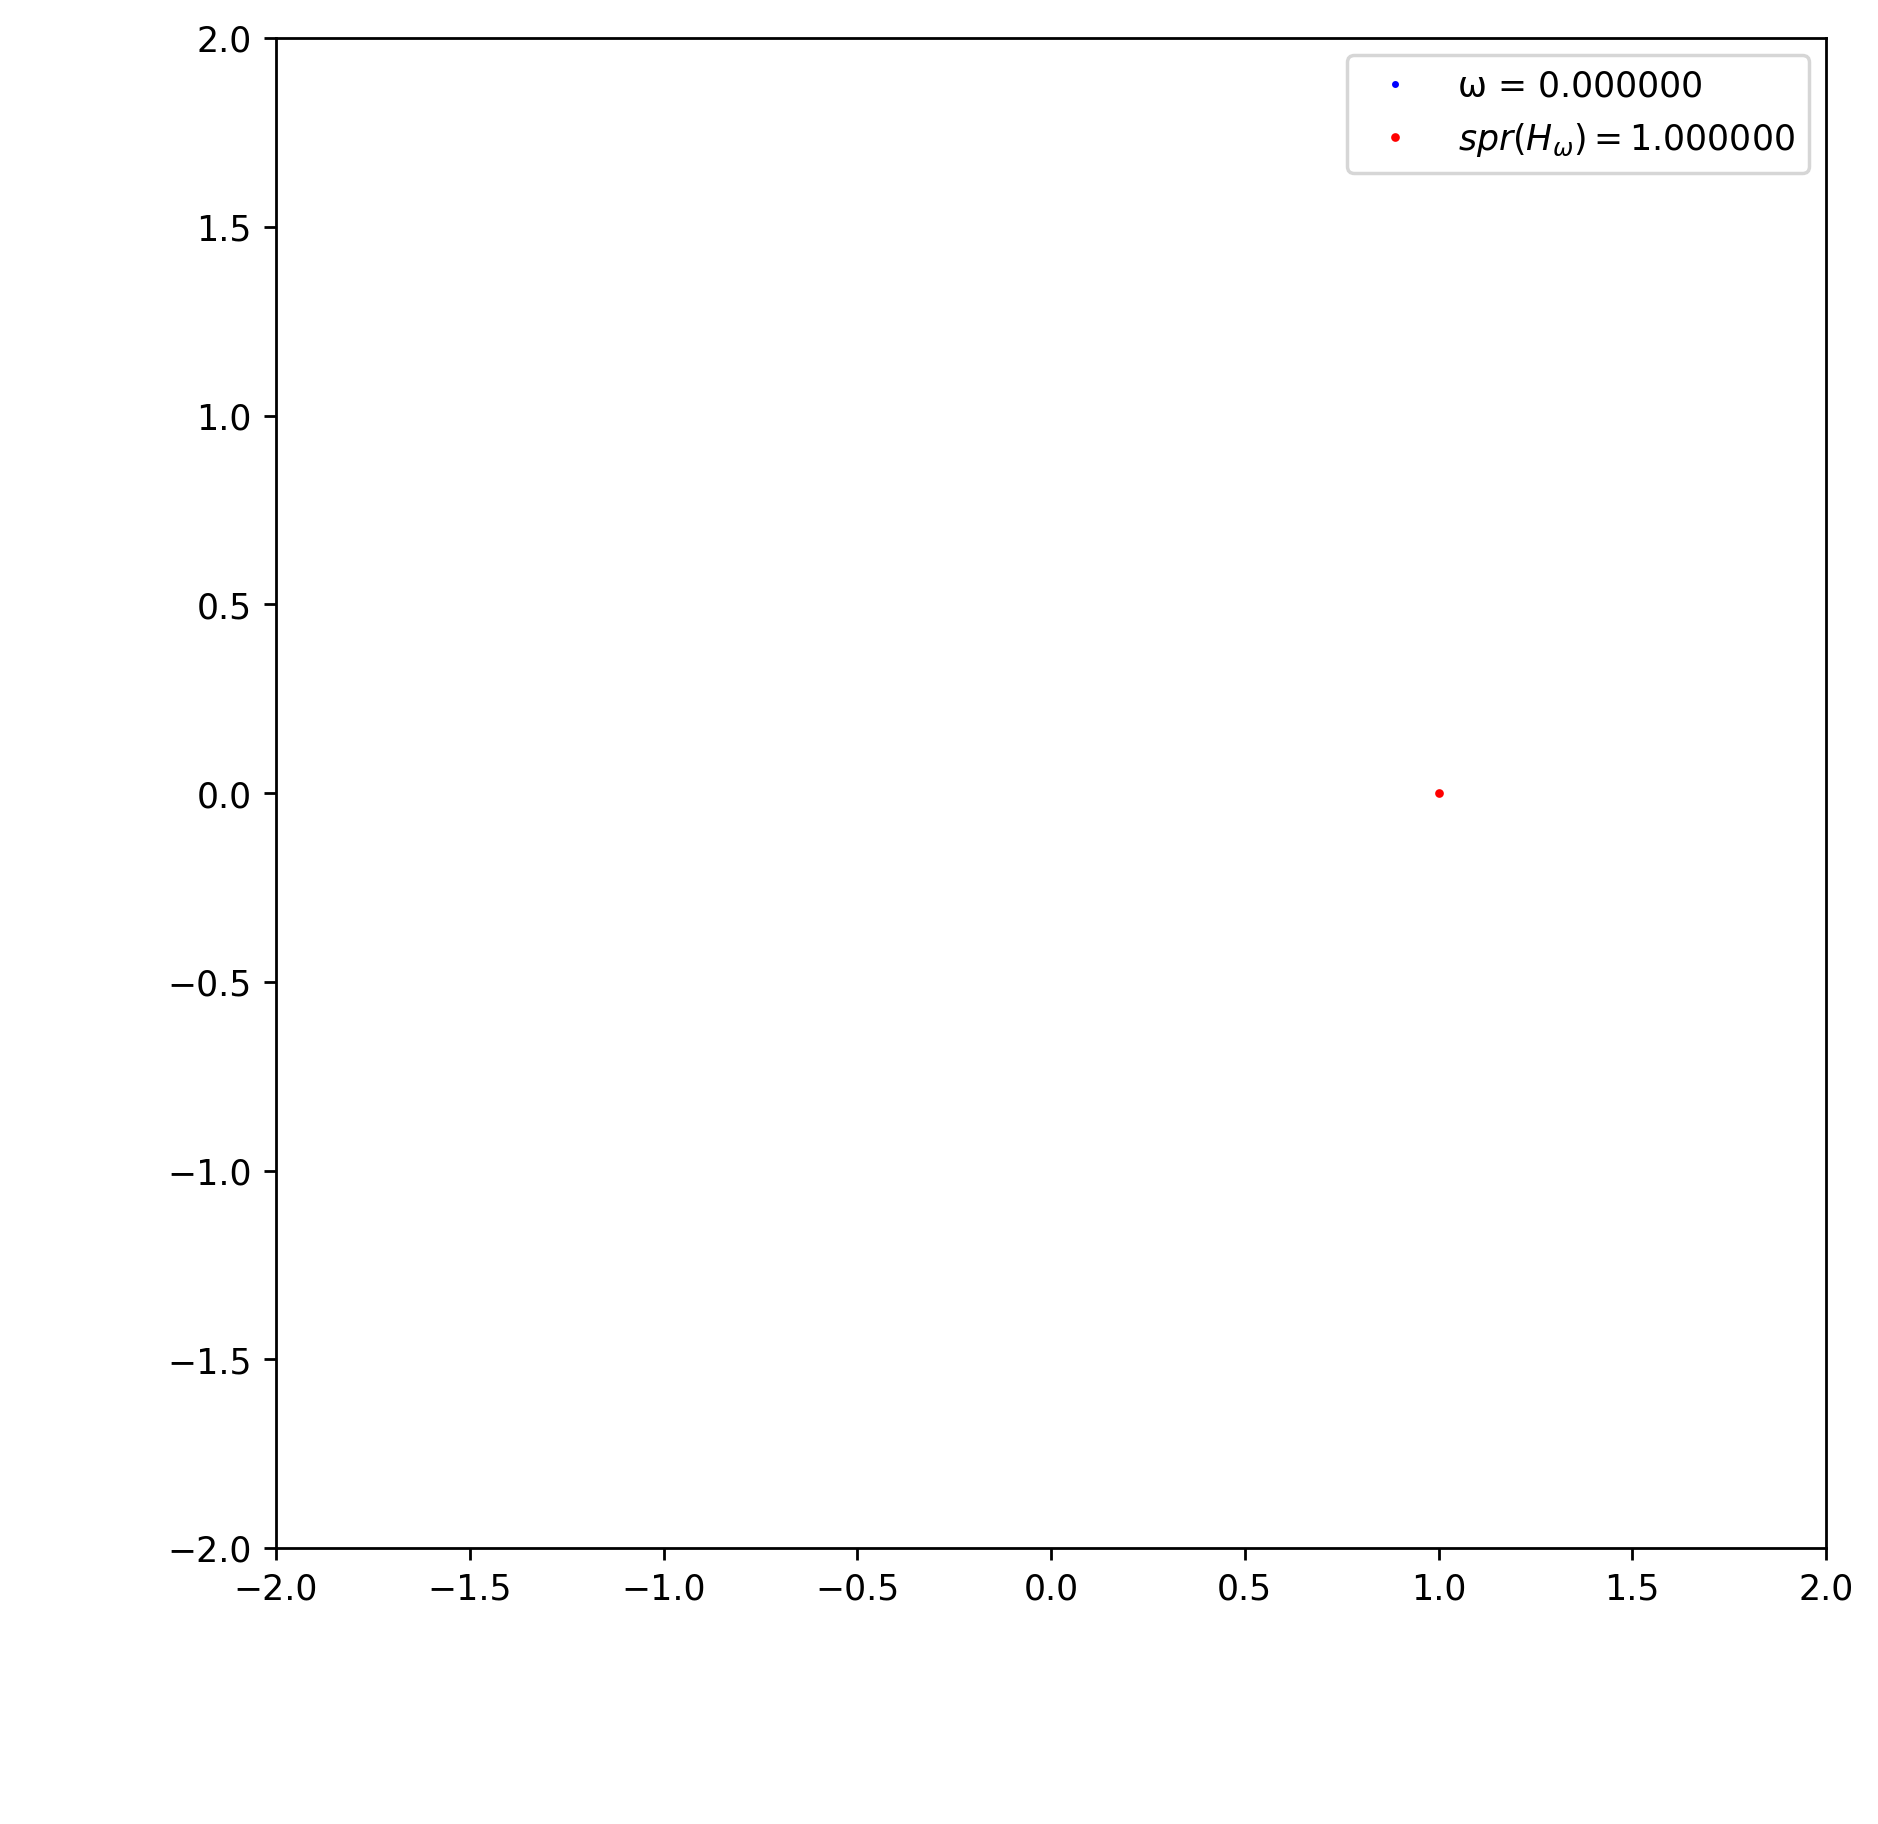

In [182]:
#fig = plt.figure(figsize=(8,8), dpi=150)
fig, ax = plt.subplots(figsize=(8,8), dpi=250)
def update(i):
    Hω = SOR(A.todense(), i)
    w, v = la.eig(Hω)
    ax.clear()
    ax.plot(w.real, w.imag, 'bo', label='ω = %f' % (i) , markersize=1)
    i = np.argmax(abs(w))
    ax.plot(w[i].real, w[i].imag, 'ro', label='$spr(H_ω) = %f$' % (abs(w[i])), markersize = 1.5)
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.legend()

a = animation.FuncAnimation(fig, update, frames=np.linspace(0, 2, num=1001))

In [183]:
a.save("text1001.mp4")